### Übungsblatt 11 - Rubin Mehralivand, Luis Schneck

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

Rechte Seite der AWA

In [174]:
def f(t: float, y: np.array):
    r = np.ndarray(3)
    r[0] = -10 * y[0] - 100 * y[1]
    r[1] = 100 * y[0] - 10 * y[1]
    r[2] = y[0] + y[1] - t * y[2]
    return r

Definition der Butcher-Tableaus und Gewichten der LMM.

In [175]:
T = np.linspace(0, 20, 1000)
A = np.array([
    [0, 0, 0, 0],
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 1, 1]
])
b = np.array([1/6, 1/3, 1/3, 1/6])
c = np.array([0, 0.5, 0.5, 1])

alpha1 = [0,-1,1]
beta1 = [-1/2, 3/2, 0]

alpha2 = [0,0,-1,1]
beta2 = [5/12, -16/12, 23/12, 0]

alphai1 = [-1,1]
betai1 = [0,1]

alphai2 = [1/3, -4/3,1]
betai2 = [0,0,1]

RK-Verfahren aus Übungsblatt 6 für die Berechnung der ersten $R$-Iterierten.

In [176]:
def runge_kutta(f: callable, initialwert: np.ndarray, T: np.ndarray, A: np.array, b, c) -> np.ndarray:
    s = A.shape[0]
    n = T.shape[0]
    y = np.zeros((n, len(initialwert)))
    y[0] = initialwert

    for m in range(n-1):
        h = T[m+1]-T[m]
        k = np.zeros((s,len(initialwert)))

        for i in range (0, s):
            k[i] = f(T[m] + c[i] * h, y[m] + h * A[i, :] @ k[:])

        y[m+1] = y[m] + h * b[:] @ k[:]

    return y

Die Implementation des expliziten LMM-Solvers mit der Formel:
$$\sum_{r=0}^R \alpha_{R-r} y_{n-r} = h \sum_{r=0}^R \beta_{R-r} f_{n-r}$$
wobei $f_{n-r} := f(t_{n-r}, y_{n-r})$. <br>
Bei der Implementation wurden die Slice-Operatoren von Python extensiv genutzt, um die for-Schleife zu sparen (die Slice-Operatoren sind schneller in der Laufzeit als for-Schleifen). Zuerst wurden die ersten $R$-Iterierten mit der RK4-Methode gefunden, danach wurden die letzten Schritte in einem extra-Array abgespeichert und die rechte Seite auf allen Punkten ausgewertet und mit den jeweiligen Gewichten "rückwärts" multipliziert (das ist das ::-1). Schlussendlich wurden die Berechneten abgespeichert und der nächste Schritt wurde begonnen.

In [177]:
def multistep_solver(f: callable, y0: np.ndarray, t0: float, T: float, h: float, alpha: np.array, beta: np.array) -> tuple:
    R = len(alpha) - 1
    steps = int((T-t0)/h)
    ys = []
    ts = []

    T_init = np.array([t0 + i * h for i in range (0,R+1)])
    y_steps = runge_kutta(f, y0, T_init, A, b, c)
    ys.extend(y_steps)
    ts.extend(T_init)


    for n in range(R, steps):
        y_past = np.array(ys[n-R:n+1][::-1])
        t_past = np.array(ts[n-R:n+1][::-1])
        f_past = np.array([f(t_past[i], y_past[i]) for i in range(R + 1)])

        y_weighted = np.dot(alpha[::-1], y_past)
        f_weighted = h * np.dot(beta[::-1], f_past)

        y_next = (f_weighted - y_weighted) / alpha[-1]
        t_next = ts[-1] + h

        ys.append(y_next)
        ts.append(t_next)

    return np.array(ts), np.array(ys)

Die Auswertung zeigt eine explosive Oszillation kurz vor $t = 1$ bei den expliziten Methoden.

Letzter Schritt t = 1: [5.51326738e+24 3.91797278e+26 3.47536929e+24]
Letzter Schritt t = 1: [-1.15692786e+31 -1.63957851e+31 -2.28356591e+28]


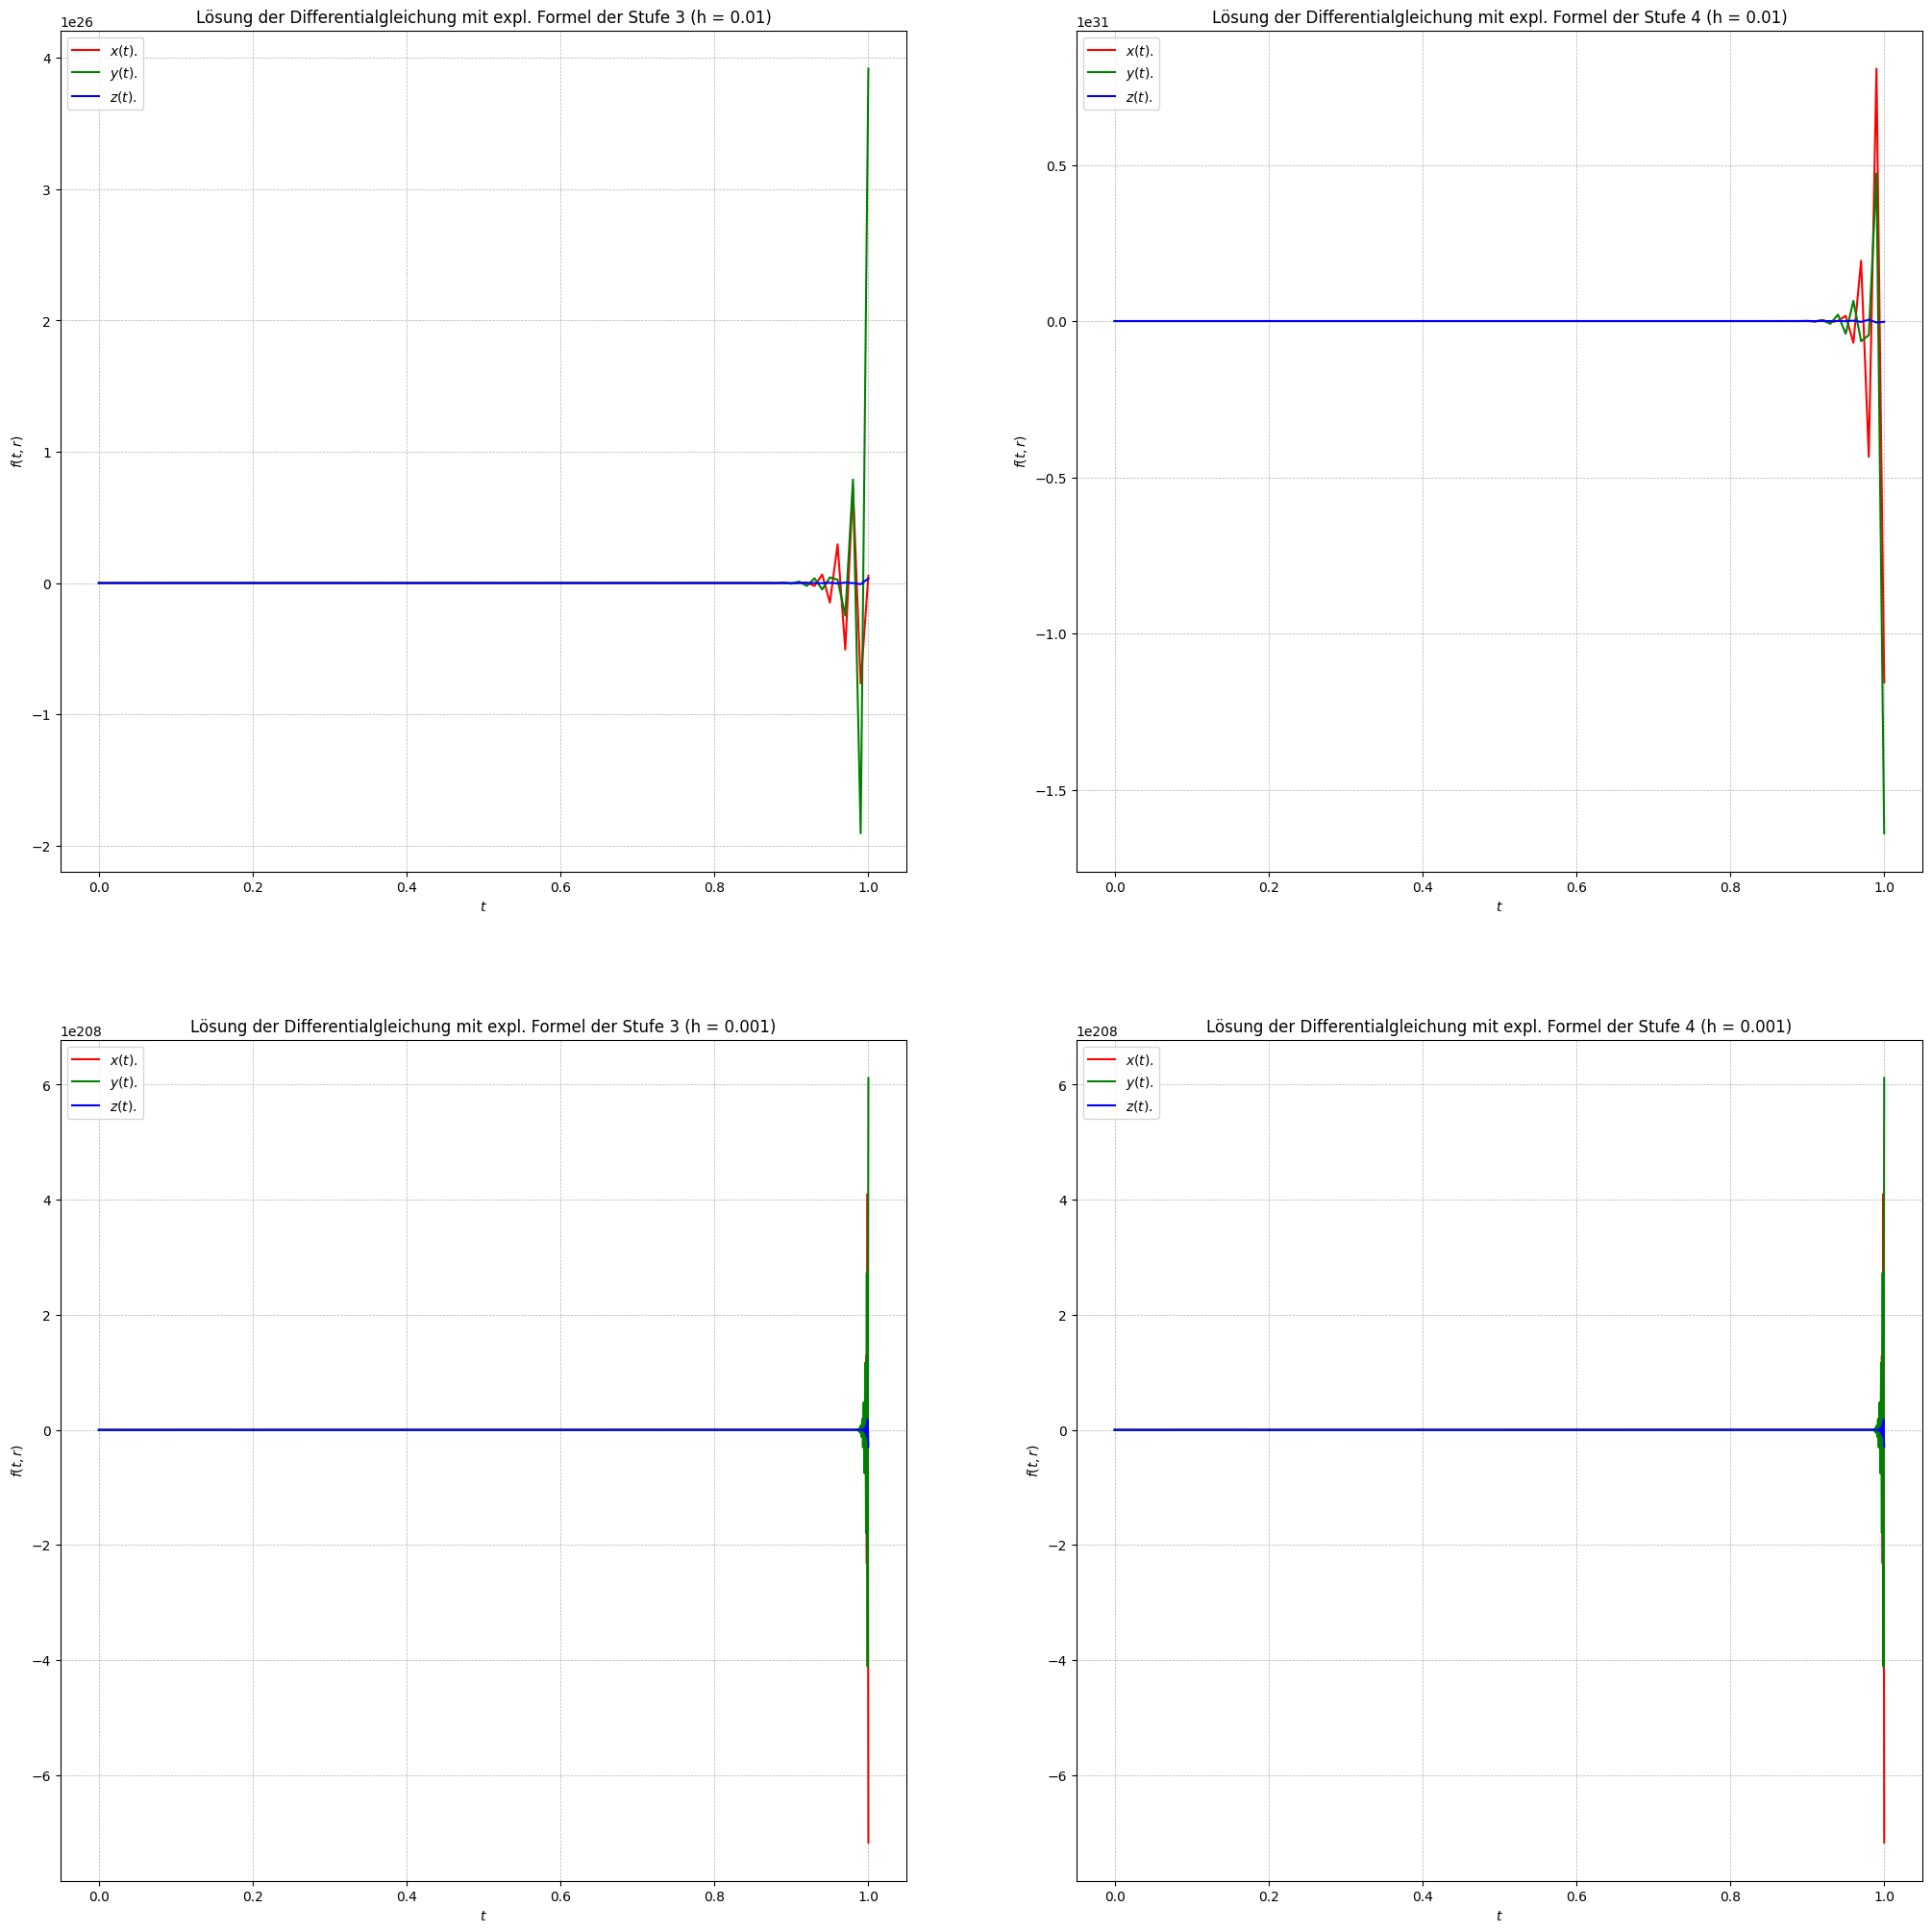

In [178]:
y0 = np.array([1,1,1])

ts, ys = multistep_solver(f, y0, 0, 1, 0.01, alpha1, beta1)
print(f"Letzter Schritt t = {int(ts[-1])}: {ys[-1]}")

plt.figure(figsize=(25, 25))

plt.subplot(2,2,1)
plt.plot(ts, ys[:,0], label='$x(t)$.', color='r')
plt.plot(ts, ys[:,1], label='$y(t)$.', color='g')
plt.plot(ts, ys[:,2], label='$z(t)$.', color='b')
plt.xlabel("$t$")
plt.ylabel("$f(t, r)$")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title(f"Lösung der Differentialgleichung mit expl. Formel der Stufe 3 (h = {0.01})")


ts, ys = multistep_solver(f, y0, 0, 1, 0.01, alpha2, beta2)
print(f"Letzter Schritt t = {int(ts[-1])}: {ys[-1]}")

plt.subplot(2,2,2)
plt.plot(ts, ys[:,0], label='$x(t)$.', color='r')
plt.plot(ts, ys[:,1], label='$y(t)$.', color='g')
plt.plot(ts, ys[:,2], label='$z(t)$.', color='b')
plt.xlabel("$t$")
plt.ylabel("$f(t, r)$")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title(f"Lösung der Differentialgleichung mit expl. Formel der Stufe 4 (h = {0.01})")

ts, ys = multistep_solver(f, y0, 0, 1, 0.001, alpha2, beta2)

plt.subplot(2,2,3)
plt.plot(ts, ys[:,0], label='$x(t)$.', color='r')
plt.plot(ts, ys[:,1], label='$y(t)$.', color='g')
plt.plot(ts, ys[:,2], label='$z(t)$.', color='b')
plt.xlabel("$t$")
plt.ylabel("$f(t, r)$")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title(f"Lösung der Differentialgleichung mit expl. Formel der Stufe 3 (h = {0.001})")

ts, ys = multistep_solver(f, y0, 0, 1, 0.001, alpha2, beta2)

plt.subplot(2,2,4)
plt.plot(ts, ys[:,0], label='$x(t)$.', color='r')
plt.plot(ts, ys[:,1], label='$y(t)$.', color='g')
plt.plot(ts, ys[:,2], label='$z(t)$.', color='b')
plt.xlabel("$t$")
plt.ylabel("$f(t, r)$")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title(f"Lösung der Differentialgleichung mit expl. Formel der Stufe 4 (h = {0.001})")

plt.show()

Für die impliziten Methoden wurde eine ähnliche Funktion implementiert, allerdings wird hier ein LGS gelöst mithilfe von scipy.optimize.fsolve, wir definieren innerhalb der Funktion eine neue Funktion, welche die folgende Gleichung löst:
$$\sum_{r=0}^R \alpha_{R-r} y_{n-r} - h \sum_{r=0}^R \beta_{R-r} f(t_{n-r}, y_{n-r}) = 0$$
Dafür brauchen wir einen Anfangswert, welcher geraten wird, dafür benutzen wir die letzte Berechnete, in der Hoffnung, dass die nächste Lösung in der Nähe ist. Der Rest stimmt größenteils mit der expliziten Methode überein.

In [179]:
def multistep_solver_impl(f: callable, y0: np.ndarray, t0: float, T: float, h: float, alpha: np.array, beta: np.array) -> tuple:
    R = len(alpha) - 1
    steps = int((T-t0)/h)
    ys = []
    ts = []

    T_init = np.array([t0 + i * h for i in range (0,R+1)])
    y_steps = runge_kutta(f, y0, T_init, A, b, c)
    ys.extend(y_steps)
    ts.extend(T_init)


    for n in range(R - 1, steps - 1):
        y_past = np.array(ys[n-R+1:n+1][::-1])
        t_past = np.array(ts[n-R+1:n+1][::-1])
        f_past = np.array([f(t_past[i], y_past[i]) for i in range(R)])
        t_next = ts[-1] + h
        y_guess = ys[-1]

        def implicit_equation(y_next: np.array) -> np.array:
            f_all = np.concatenate(([f(t_next, y_next)], f_past))
            y_all = np.array([y_next] + list(y_past))
            y_weighted = np.dot(alpha[::-1], y_all)
            f_weighted = h * np.dot(beta[::-1], f_all)
            return y_weighted - f_weighted

        y_next = fsolve(implicit_equation, y_guess)
        ys.append(y_next)
        ts.append(t_next)

    return np.array(ts), np.array(ys)

Die Auswertung auf den impliziten Methoden ergibt eine wesentlich stabilere Oszillation, die allerdings bei kleineren Schrittweiten immer noch explodiert, jedoch nicht so stark wie die expliziten Methoden.

Letzter Schritt t = 1: [ 3.47211153e-09 -7.97360324e-11  7.77110599e-01]
Letzter Schritt t = 1: [ 2.31898011e+01 -1.25117860e+01 -7.11894372e+04]


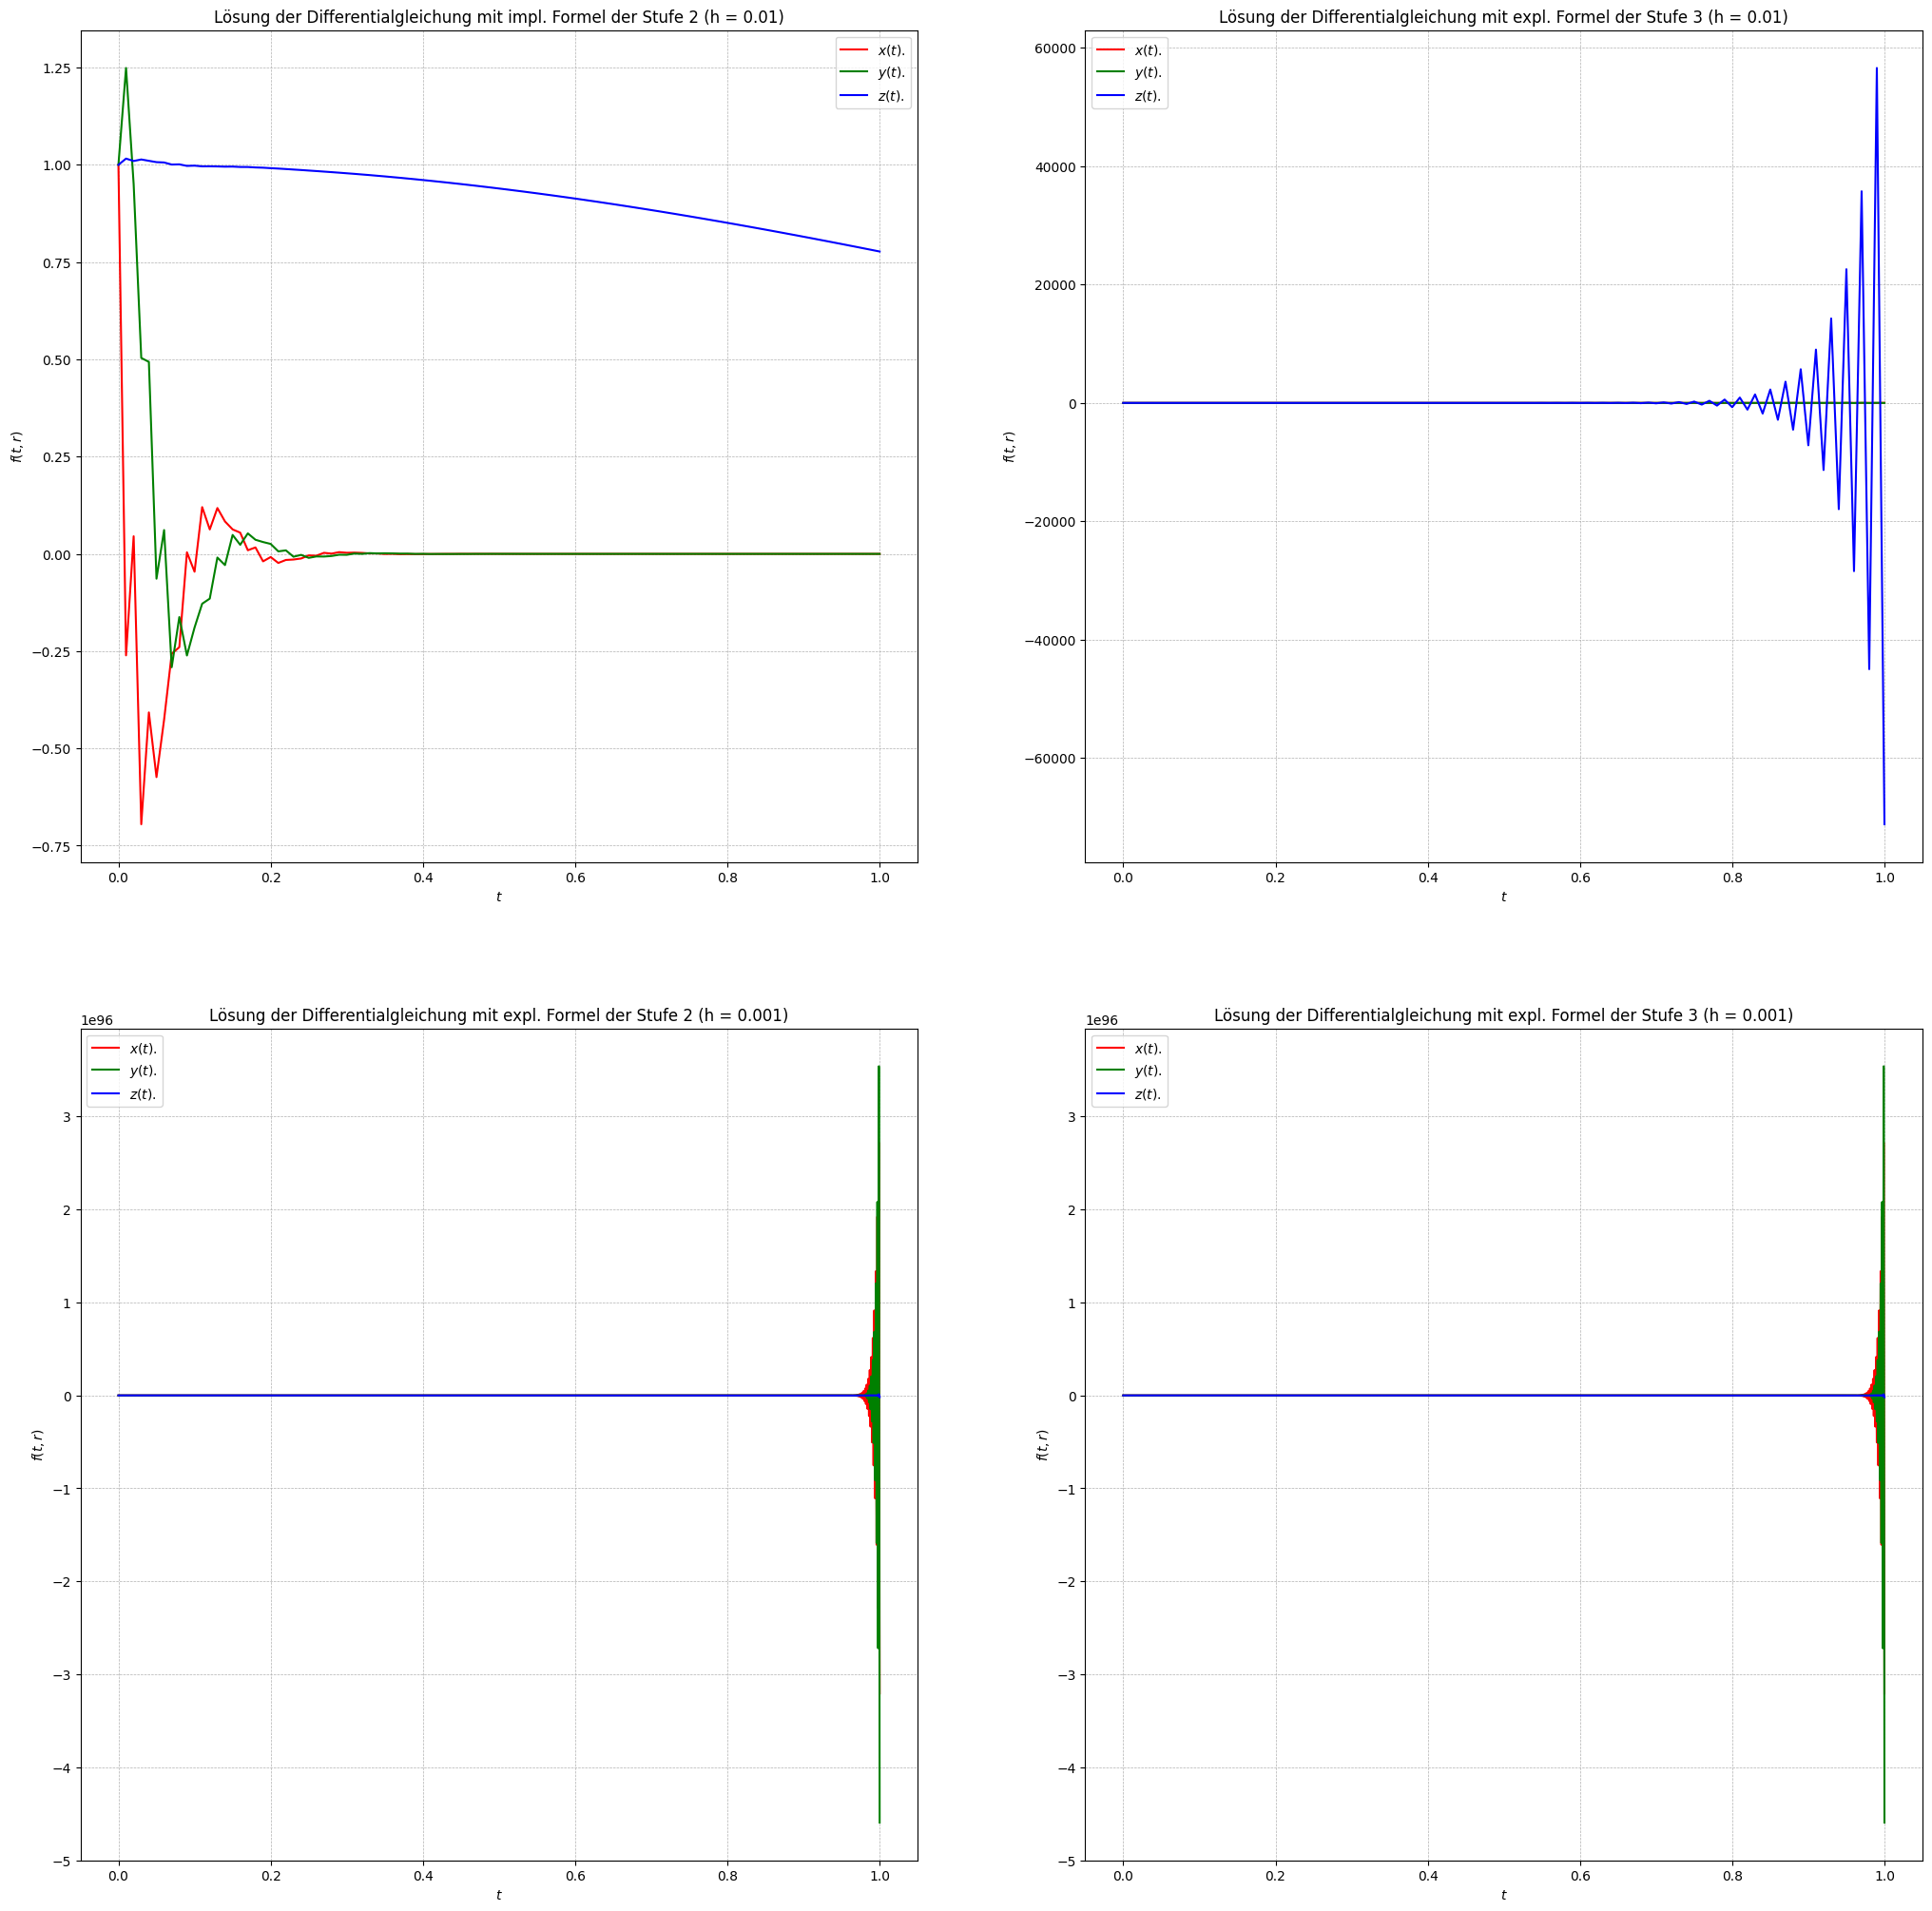

In [180]:
y0 = np.array([1,1,1])

ts, ys = multistep_solver_impl(f, y0, 0, 1, 0.01, alphai1, betai1)
print(f"Letzter Schritt t = {int(ts[-1])}: {ys[-1]}")

plt.figure(figsize=(25, 25))

plt.subplot(2,2,1)
plt.plot(ts, ys[:,0], label='$x(t)$.', color='r')
plt.plot(ts, ys[:,1], label='$y(t)$.', color='g')
plt.plot(ts, ys[:,2], label='$z(t)$.', color='b')
plt.xlabel("$t$")
plt.ylabel("$f(t, r)$")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title(f"Lösung der Differentialgleichung mit impl. Formel der Stufe 2 (h = {0.01})")


ts, ys = multistep_solver_impl(f, y0, 0, 1, 0.01, alphai2, betai2)
print(f"Letzter Schritt t = {int(ts[-1])}: {ys[-1]}")

plt.subplot(2,2,2)
plt.plot(ts, ys[:,0], label='$x(t)$.', color='r')
plt.plot(ts, ys[:,1], label='$y(t)$.', color='g')
plt.plot(ts, ys[:,2], label='$z(t)$.', color='b')
plt.xlabel("$t$")
plt.ylabel("$f(t, r)$")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title(f"Lösung der Differentialgleichung mit expl. Formel der Stufe 3 (h = {0.01})")

ts, ys = multistep_solver_impl(f, y0, 0, 1, 0.001, alphai2, betai2)

plt.subplot(2,2,3)
plt.plot(ts, ys[:,0], label='$x(t)$.', color='r')
plt.plot(ts, ys[:,1], label='$y(t)$.', color='g')
plt.plot(ts, ys[:,2], label='$z(t)$.', color='b')
plt.xlabel("$t$")
plt.ylabel("$f(t, r)$")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title(f"Lösung der Differentialgleichung mit expl. Formel der Stufe 2 (h = {0.001})")

ts, ys = multistep_solver_impl(f, y0, 0, 1, 0.001, alphai2, betai2)

plt.subplot(2,2,4)
plt.plot(ts, ys[:,0], label='$x(t)$.', color='r')
plt.plot(ts, ys[:,1], label='$y(t)$.', color='g')
plt.plot(ts, ys[:,2], label='$z(t)$.', color='b')
plt.xlabel("$t$")
plt.ylabel("$f(t, r)$")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title(f"Lösung der Differentialgleichung mit expl. Formel der Stufe 3 (h = {0.001})")

plt.show()